# Implementation of a Newton–Raphson solver for nonlinear elasticity

In this notebook, we will analyse the same problem as in the previous notebook [HyperelasticSolid.ipynb](HyperelasticSolid.ipynb). However, this time, we will implement or own Newton–Raphson solver, rather than rely on FEniCS's `NonlinearVariationalSolver`.

You need to fill in the blank lines that are indicated s follows
```
# COMPLETE THIS LINE
```

Until you do that, the Notebook will *not* work properly.

## Setting up the problem

The code below is merely a copy/paste of the code from the previous sessions, as we use the same problem to illustrate the implementation of the Newton–Raphson iterations

We first import and setup the usual modules.

In [1]:
import dolfin
import ufl
import numpy as np
import matplotlib.pyplot as plt
import os.path

%matplotlib inline

dolfin.parameters["form_compiler"]["cpp_optimize"] = True
dolfin.parameters["form_compiler"]["representation"] = "uflacs"
plt.style.use("seaborn-notebook")

### Parameters of the simulation

Place here the parameters that can be changed without altering the logics of the code.

In [2]:
Lx, Ly = 1.0, 0.1 # Dimensions of the beam
nx, ny = 20, 5 # Number of elements in each direction
# nx, ny = 60, 10 # Number of elements in each direction
Y, nu = 1e3, 0.3 # Young modulus and Poisson ratio
load_min, load_max, nsteps = 0.0, 0.3, 40 # Loading schedule
degree = 2

output_dir = "nr_output"
print( 6*Lx**3/((1+nu)*Ly**2) ) # Gamma / t

461.53846153846143


You should not alter the cell below

In [3]:
loads = np.linspace(load_min, load_max, nsteps)

mu = dolfin.Constant(Y/(2*(1 + nu)))
lmbda = dolfin.Constant(Y*nu/((1 + nu)*(1 - 2*nu)))
lmbda = 2*lmbda*mu/(lmbda + 2*mu) 

### Mesh

In [4]:
mesh = dolfin.RectangleMesh(dolfin.Point(0,0),
                            dolfin.Point(Lx,Ly),
                            nx, ny)
left = dolfin.CompiledSubDomain("near(x[0],0) && on_boundary")
right = dolfin.CompiledSubDomain("near(x[0],Lx) && on_boundary", Lx=Lx)

boundary_markers = dolfin.MeshFunction("size_t", mesh, 1, 0)
boundary_indices = {"left": 1, "right": 2}
left.mark(boundary_markers, boundary_indices["left"])
right.mark(boundary_markers, boundary_indices["right"])

ds = dolfin.ds(domain=mesh,subdomain_data=boundary_markers)
dx = dolfin.dx(domain=mesh)

### Function space

In [5]:
V_element = dolfin.VectorElement("CG", mesh.ufl_cell(), degree=degree) 
V = dolfin.FunctionSpace(mesh, V_element)
u = dolfin.Function(V, name="u")

### Potential energy

We first define the strain energy of a (compressible) neo-Hookean material.

In [6]:
I = ufl.Identity(2)    
F = ufl.variable(I+ufl.grad(u))  
C = F.T*F                   
Ic = ufl.tr(C)
J  = ufl.det(F)
E = 1/2*(C-I)

psi = (mu/2)*(Ic-2)-mu*ufl.ln(J)+(lmbda/2)*(ufl.ln(J))**2

We then define the loading (body forces $\mathbf{B}$).

In [7]:
B = dolfin.Expression(("0.0", "mu*t"), t=0, mu=mu, degree=0)
# B = dolfin.Expression(("mu*t*cos(alpha)", "mu*t*sin(alpha)"), t=0.01, mu=mu, alpha=np.pi/2, degree=0)
# B = dolfin.Expression(("0.0", "0.0"), t=0, mu=mu, degree=0)
T = mu*dolfin.Constant((0.0, 0.0))

We can now define the potential energy and its derivatives w.r.t the displacement $\mathbf{u}$.

In [8]:
potential_energy = psi*dx-ufl.dot(B, u)*dx-ufl.dot(T, u)*ds(boundary_indices['right'])
residual = ufl.derivative(potential_energy, u, dolfin.TestFunction(V))
jacobian = ufl.derivative(residual, u, dolfin.TrialFunction(V))

Boundary conditions for a built-in support on the left-hand side.

In [11]:
bcs = [dolfin.DirichletBC(V, (0.,0.), left), dolfin.DirichletBC(V, (0, 0.001), right)]
bcs = [dolfin.DirichletBC(V, (0.,0.), left)]

### Computing the reference solution

We use the built-in non-linear solver to compute a reference solution, which we will compare to the solution computed with our own NR solver.

Text(0, 0.5, 'end-displacement')

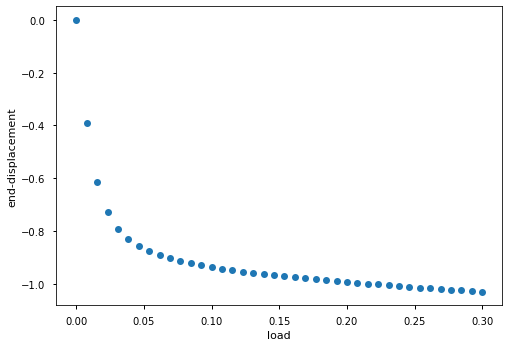

In [12]:
problem = dolfin.NonlinearVariationalProblem(residual, u, bcs=bcs, J=jacobian)
solver = dolfin.NonlinearVariationalSolver(problem)
displ_ref = np.zeros_like(loads)
u.interpolate(dolfin.Constant((0., 0.)))
file_u = dolfin.XDMFFile(os.path.join(output_dir, "u_ref.xdmf"))
file_u.parameters.update({"flush_output":True,
                          "functions_share_mesh":True,
                          "rewrite_function_mesh":False})
for (i, t) in enumerate(loads):
    B.t = -t
    solver.solve()
    displ_ref[i] = dolfin.assemble(u[1]*ds(boundary_indices["right"]))/Ly 
    #print("t={:+3.3f}, u={:+3.3f}".format(t,displ_ref[i]))
    with file_u as file:
        file.write(u,t)
plt.plot(loads,displ_ref, "o")
plt.xlabel("load")
plt.ylabel("end-displacement")

## Implementation of the Newton–Raphson solver

We will discuss the statement below in class.

In [13]:
def simple_monitor(iteration, u, norm_u, norm_delta_u, norm_residual):
    print("Iteration: {:3d}, Error: {:3.4e}, Residual: {:3.4e}".format(iteration, norm_delta_u, norm_residual))
        
def plot_monitor(iteration, u, norm_u, norm_delta_u, norm_residual):
    simple_monitor(iteration, u, norm_u, norm_delta_u, norm_residual)
    plt.figure()
    dolfin.plot(u, mode="displacement") 

def newton_solver(u, max_iter=100, rtol=1e-6, atol=1e-6, monitor=None):
    delta_u = dolfin.Function(V)
    delta_u.interpolate(dolfin.Constant((0., 0.)))
    for k in range(max_iter):
        # Solve the linearized problem for the increment delta_u with homogenous BCs
        residual = ufl.derivative(potential_energy, u, dolfin.TestFunction(V))
        jacobian = ufl.derivative(residual, u, dolfin.TrialFunction(V))
        # jacobian = I

        # bc
        dolfin.solve(jacobian == -residual, delta_u, bcs[0])
        # Update the solution
        u.assign(u+delta_u)
        # Stopping criterion based on the L2 norm of u and delta_u
        norm_delta_u = dolfin.norm(delta_u, 'L2')
        norm_u = dolfin.norm(u, 'L2')
        intR = dolfin.assemble(residual)
        bcs[0].apply(intR)
        # bcs[1].apply(intR)
        # We will compute this norm together
        norm_residual = dolfin.norm(intR, 'L2')
        if monitor is not None:
            monitor(k, u, norm_u, norm_delta_u, norm_residual)
        # COMPLETE THIS LINE: IMPLEMENT TEST
        if norm_residual < atol:
            break
    else:
        # See for-else statement:
        # https://book.pythontips.com/en/latest/for_-_else.html#else-clause
        # This block is entered only if the above loop completes,
        # which means that the maximum number of iterations has been reached.
        raise RuntimeError("could not converge, norm_u {}, norm_delta_u {}".format(norm_u, norm_delta_u)) 
    return k

We are now ready to call our solver, first with a very small load, so that the solution is nearly that of the linear problem, and the algorithm should converge in one iteration.

In [14]:
u.interpolate(dolfin.Constant((0., 0.)))
B.t = load_max/1e4
# B.t = 0.0001
newton_solver(u, monitor=simple_monitor)

Iteration:   0, Error: 2.8053e-04, Residual: 6.6787e-04
Iteration:   1, Error: 2.5510e-07, Residual: 1.5483e-09


1

Let's try a slightly higher load. We will plot the estimate of the solution at each iteration. It is interesting to observe the iterates converge to the solution.

Iteration:   0, Error: 1.0520e-01, Residual: 6.5232e+01
Iteration:   1, Error: 3.8581e-02, Residual: 2.1507e+01
Iteration:   2, Error: 6.0578e-03, Residual: 1.5356e+00
Iteration:   3, Error: 2.3358e-03, Residual: 2.0823e-01
Iteration:   4, Error: 6.9049e-04, Residual: 5.6062e-03
Iteration:   5, Error: 1.7274e-04, Residual: 2.4165e-04
Iteration:   6, Error: 1.7361e-06, Residual: 2.8757e-08


6

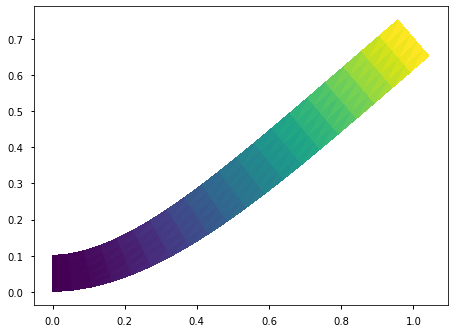

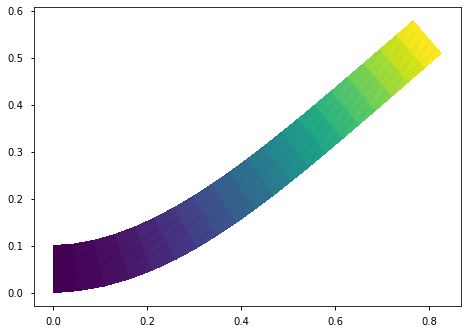

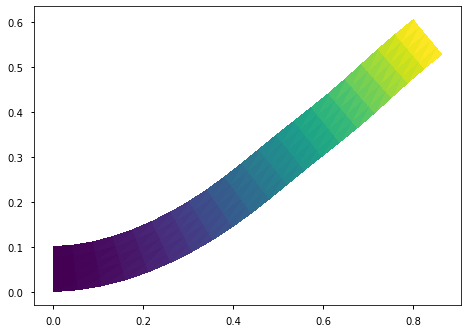

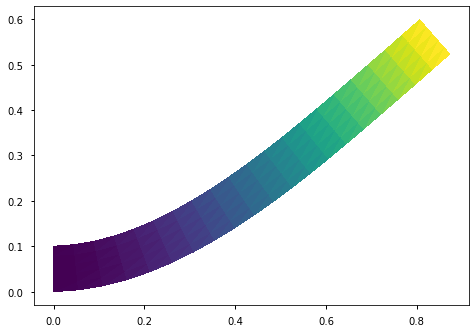

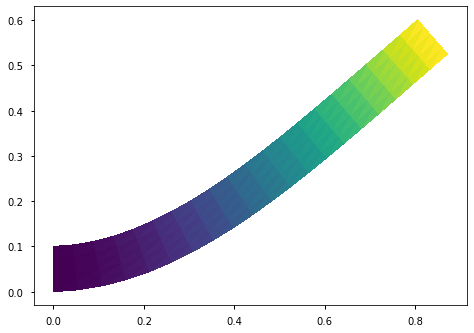

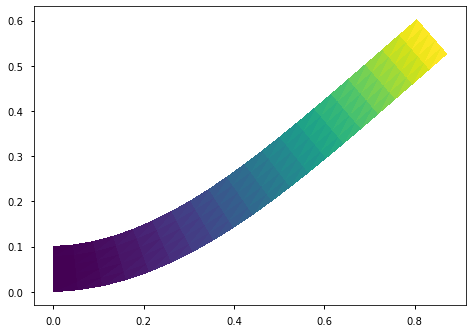

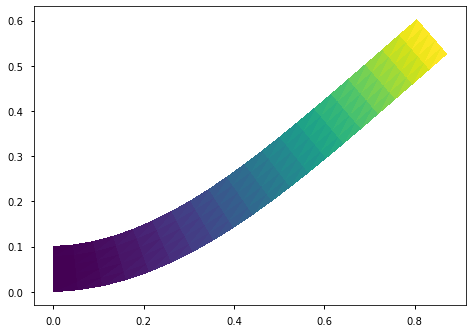

In [15]:
u.interpolate(dolfin.Constant((0., 0.)))
B.t = 1.5*load_max/nsteps
newton_solver(u, monitor=plot_monitor)

### Illustrating quadratic convergence

We now want to verify that the Newton–Raphson iterations converge quadratically, that is $\epsilon_{n+1} \leq C\epsilon_n^2$, where $\epsilon_n$ denotes the error of the $n$-th iterate. Since we do not know the exact solution of the problem, we will take the last iterate as a reference.

We implement a new `monitor` that keeps a copy of each iterate.

In [16]:
iterates = []
def my_monitor(iteration, u, u_norm, delta_u_norm, residual_norm):
    simple_monitor(iteration, u, u_norm, delta_u_norm, residual_norm)
    iterates.append(u.copy(deepcopy=True))

u.interpolate(dolfin.Constant((0., 0.)))
B.t = 2.5*load_max/nsteps
newton_solver(u, monitor=my_monitor, rtol=1e-10, atol=1e-10)

Iteration:   0, Error: 1.7533e-01, Residual: 1.2550e+02
Iteration:   1, Error: 1.0720e-01, Residual: 1.2656e+02
Iteration:   2, Error: 2.1334e-02, Residual: 3.2395e+01
Iteration:   3, Error: 7.5194e-03, Residual: 7.0600e+00
Iteration:   4, Error: 8.4833e-03, Residual: 2.4115e+00
Iteration:   5, Error: 1.8835e-03, Residual: 1.3992e-01
Iteration:   6, Error: 1.5271e-03, Residual: 2.1435e-02
Iteration:   7, Error: 1.6149e-04, Residual: 3.4215e-04
Iteration:   8, Error: 9.0521e-06, Residual: 1.1311e-06
Iteration:   9, Error: 8.5328e-09, Residual: 2.5950e-12


9

In [17]:
L2_errors = np.zeros(len(iterates), dtype=np.float64)
H1_errors = np.zeros_like(L2_errors)
u_ref = iterates[-1]
for i, u_i in enumerate(iterates):
    L2_errors[i] = dolfin.errornorm(u_ref, u_i, 'L2')
    H1_errors[i] = dolfin.errornorm(u_ref, u_i, 'H1')

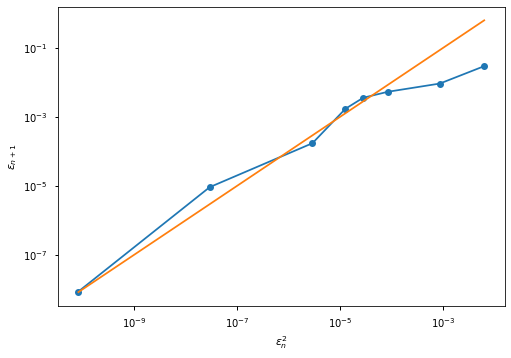

In [18]:
plt.xlabel(r'$\epsilon_n^2$')
plt.ylabel(r'$\epsilon_{n+1}$')

plt.loglog(L2_errors[:-2]**2, L2_errors[1:-1], 'o-')
plt.loglog(L2_errors[:-2]**2, 100*L2_errors[:-2]**2)

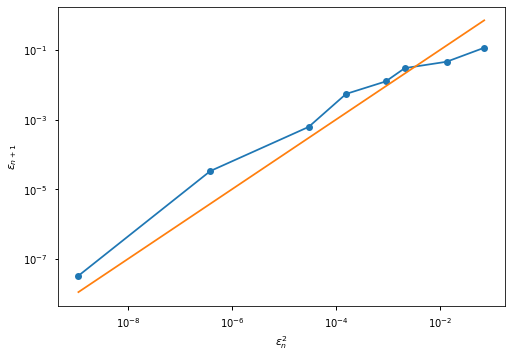

In [19]:
plt.xlabel(r'$\epsilon_n^2$')
plt.ylabel(r'$\epsilon_{n+1}$')

plt.loglog(H1_errors[:-2]**2, H1_errors[1:-1], 'o-')
plt.loglog(H1_errors[:-2]**2, 10*H1_errors[:-2]**2)

## Validation of the solver

We now run the whole simulation and compare with the reference solution.

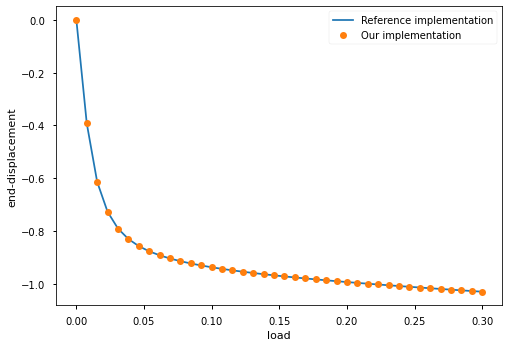

In [20]:
displ = np.zeros_like(loads)
u.interpolate(dolfin.Constant((0.,0.)))
file_u = dolfin.XDMFFile(os.path.join(output_dir, "u.xdmf"))
file_u.parameters.update({"flush_output":True,
                          "functions_share_mesh":True,
                          "rewrite_function_mesh":False})
for (i, t) in enumerate(loads):
    B.t = -t
    newton_solver(u)
    displ[i] = dolfin.assemble(u[1]*ds(2))/Ly 
    #print("t={:+3.3f}, u={:+3.3f}".format(t,displ_ref[i]))
    with file_u as file:
        file.write(u,t)

plt.plot(loads, displ_ref, "-", label='Reference implementation')
plt.plot(loads, displ, 'o', label='Our implementation')
plt.xlabel("load")
plt.ylabel("end-displacement")
plt.legend()

# `Further questions`

Question 0 Sometimes the Jacobian is too difficult to compute, try to replace it by the Identity (of the right dimension) and see if your obtain convergence

In [38]:
u.interpolate(dolfin.Constant((0., 0.)))
B.t = 1.5*load_max/nsteps
newton_solver(u, monitor=simple_monitor)

TypeError: solve(): incompatible function arguments. The following argument types are supported:
    1. (A: dolfin.cpp.la.GenericLinearOperator, x: dolfin.cpp.la.GenericVector, b: dolfin.cpp.la.GenericVector, method: str = 'lu', preconditioner: str = 'none') -> int

Invoked with: False, Coefficient(FunctionSpace(Mesh(VectorElement(FiniteElement('Lagrange', triangle, 1), dim=2), 2), VectorElement(FiniteElement('Lagrange', triangle, 2), dim=2)), 4294), <dolfin.fem.dirichletbc.DirichletBC object at 0x7f3c5be48bd0>, 'default', 'default'

**Question 1** Show that for large load steps, the iterations may cease to converge. Can you explain what is happening? 

In [47]:
u.interpolate(dolfin.Constant((0., 0.)))
B.t = load_max/16
newton_solver(u, monitor=simple_monitor)

Iteration:   0, Error: 1.7533e-01, Residual: 1.2550e+02
Iteration:   1, Error: 1.0720e-01, Residual: 1.2656e+02
Iteration:   2, Error: 2.1334e-02, Residual: 3.2395e+01
Iteration:   3, Error: 7.5194e-03, Residual: 7.0600e+00
Iteration:   4, Error: 8.4833e-03, Residual: 2.4115e+00
Iteration:   5, Error: 1.8835e-03, Residual: 1.3992e-01
Iteration:   6, Error: 1.5271e-03, Residual: 2.1435e-02
Iteration:   7, Error: 1.6149e-04, Residual: 3.4215e-04
Iteration:   8, Error: 9.0521e-06, Residual: 1.1311e-06
Iteration:   9, Error: 8.5328e-09, Residual: 2.5950e-12


9

In [48]:
u.interpolate(dolfin.Constant((0., 0.)))
B.t = load_max/15
newton_solver(u, monitor=simple_monitor)

Iteration:   0, Error: 1.8702e-01, Residual: 1.3485e+02
Iteration:   1, Error: 1.2099e-01, Residual: 1.6022e+02
Iteration:   2, Error: 2.3944e-02, Residual: 4.5656e+01
Iteration:   3, Error: 1.2650e-02, Residual: 1.3442e+01
Iteration:   4, Error: 5.0618e-02, Residual: 3.5092e+01
Iteration:   5, Error: 1.1695e-02, Residual: 9.5489e+00
Iteration:   6, Error: 1.1141e-01, Residual: 1.7784e+02
Iteration:   7, Error: 6.3098e-02, Residual: nan
Iteration:   8, Error: nan, Residual: nan
Iteration:   9, Error: nan, Residual: nan
Iteration:  10, Error: nan, Residual: nan
Iteration:  11, Error: nan, Residual: nan
Iteration:  12, Error: nan, Residual: nan
Iteration:  13, Error: nan, Residual: nan
Iteration:  14, Error: nan, Residual: nan
Iteration:  15, Error: nan, Residual: nan
Iteration:  16, Error: nan, Residual: nan
Iteration:  17, Error: nan, Residual: nan
Iteration:  18, Error: nan, Residual: nan
Iteration:  19, Error: nan, Residual: nan
Iteration:  20, Error: nan, Residual: nan
Iteration:  2

RuntimeError: could not converge, norm_u nan, norm_delta_u nan

**Question 2** Refine the mesh and observe how the largest load-step is affected.

In [78]:
print('nx =', nx, 'ny =', ny)

nx = 60 ny = 10


In [76]:
u.interpolate(dolfin.Constant((0., 0.)))
B.t = load_max/16
newton_solver(u, monitor=simple_monitor)

Iteration:   0, Error: 1.7562e-01, Residual: 7.3204e+01
Iteration:   1, Error: 1.0747e-01, Residual: 7.4266e+01
Iteration:   2, Error: 2.1612e-02, Residual: 2.1799e+01
Iteration:   3, Error: 7.7333e-03, Residual: 7.8288e+00
Iteration:   4, Error: 4.8911e-03, Residual: 1.2323e+00
Iteration:   5, Error: 1.5035e-03, Residual: 3.6199e-01
Iteration:   6, Error: 3.8978e-04, Residual: 5.9544e-03
Iteration:   7, Error: 4.9819e-05, Residual: 6.3609e-05
Iteration:   8, Error: 3.5191e-07, Residual: 1.2992e-09


8

In [77]:
u.interpolate(dolfin.Constant((0., 0.)))
B.t = load_max/15
newton_solver(u, monitor=simple_monitor)

Iteration:   0, Error: 1.8733e-01, Residual: 7.8645e+01
Iteration:   1, Error: 1.2129e-01, Residual: 9.4035e+01
Iteration:   2, Error: 2.3699e-02, Residual: 2.8405e+01
Iteration:   3, Error: 2.2052e-02, Residual: nan
Iteration:   4, Error: nan, Residual: nan
Iteration:   5, Error: nan, Residual: nan
Iteration:   6, Error: nan, Residual: nan
Iteration:   7, Error: nan, Residual: nan
Iteration:   8, Error: nan, Residual: nan
Iteration:   9, Error: nan, Residual: nan
Iteration:  10, Error: nan, Residual: nan
Iteration:  11, Error: nan, Residual: nan
Iteration:  12, Error: nan, Residual: nan
Iteration:  13, Error: nan, Residual: nan
Iteration:  14, Error: nan, Residual: nan
Iteration:  15, Error: nan, Residual: nan
Iteration:  16, Error: nan, Residual: nan
Iteration:  17, Error: nan, Residual: nan
Iteration:  18, Error: nan, Residual: nan
Iteration:  19, Error: nan, Residual: nan
Iteration:  20, Error: nan, Residual: nan
Iteration:  21, Error: nan, Residual: nan
Iteration:  22, Error: nan,

RuntimeError: could not converge, norm_u nan, norm_delta_u nan

**Question 3** Replace the distributed loading with a prescribed vertical displacement at the tip of the cantilever.

Iteration:   0, Error: 1.9269e-04, Residual: 3.3251e-03
Iteration:   1, Error: 1.9269e-04, Residual: 3.3251e-03
Iteration:   2, Error: 1.9269e-04, Residual: 3.3251e-03
Iteration:   3, Error: 1.9269e-04, Residual: 3.3251e-03
Iteration:   4, Error: 1.9269e-04, Residual: 3.3251e-03
Iteration:   5, Error: 1.9269e-04, Residual: 3.3251e-03
Iteration:   6, Error: 1.9268e-04, Residual: 3.3251e-03
Iteration:   7, Error: 1.9268e-04, Residual: 3.3251e-03
Iteration:   8, Error: 1.9268e-04, Residual: 3.3251e-03
Iteration:   9, Error: 1.9267e-04, Residual: 3.3251e-03
Iteration:  10, Error: 1.9267e-04, Residual: 3.3251e-03
Iteration:  11, Error: 1.9266e-04, Residual: 3.3251e-03
Iteration:  12, Error: 1.9266e-04, Residual: 3.3251e-03
Iteration:  13, Error: 1.9265e-04, Residual: 3.3251e-03
Iteration:  14, Error: 1.9265e-04, Residual: 3.3251e-03
Iteration:  15, Error: 1.9264e-04, Residual: 3.3251e-03
Iteration:  16, Error: 1.9263e-04, Residual: 3.3251e-03
Iteration:  17, Error: 1.9262e-04, Residual: 3.3

<ipython-input-65-9240c174697e>:6: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()


Iteration:  22, Error: 1.9258e-04, Residual: 3.3250e-03
Iteration:  23, Error: 1.9257e-04, Residual: 3.3250e-03
Iteration:  24, Error: 1.9255e-04, Residual: 3.3250e-03
Iteration:  25, Error: 1.9254e-04, Residual: 3.3250e-03
Iteration:  26, Error: 1.9253e-04, Residual: 3.3250e-03
Iteration:  27, Error: 1.9252e-04, Residual: 3.3250e-03
Iteration:  28, Error: 1.9251e-04, Residual: 3.3249e-03
Iteration:  29, Error: 1.9249e-04, Residual: 3.3249e-03
Iteration:  30, Error: 1.9248e-04, Residual: 3.3249e-03
Iteration:  31, Error: 1.9246e-04, Residual: 3.3249e-03
Iteration:  32, Error: 1.9245e-04, Residual: 3.3249e-03
Iteration:  33, Error: 1.9243e-04, Residual: 3.3249e-03
Iteration:  34, Error: 1.9242e-04, Residual: 3.3249e-03
Iteration:  35, Error: 1.9240e-04, Residual: 3.3248e-03
Iteration:  36, Error: 1.9239e-04, Residual: 3.3248e-03
Iteration:  37, Error: 1.9237e-04, Residual: 3.3248e-03
Iteration:  38, Error: 1.9235e-04, Residual: 3.3248e-03
Iteration:  39, Error: 1.9234e-04, Residual: 3.3

RuntimeError: could not converge, norm_u 0.019197966822626266, norm_delta_u 0.00019072923022323053

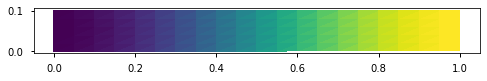

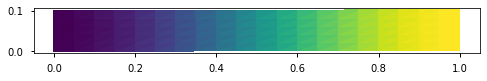

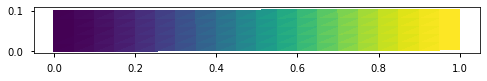

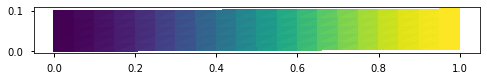

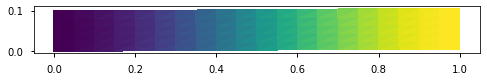

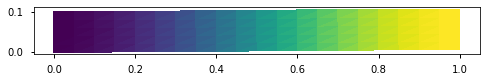

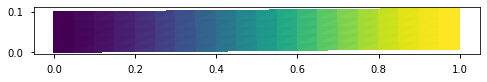

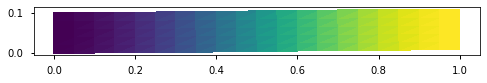

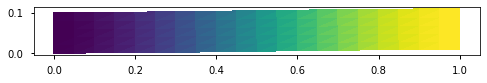

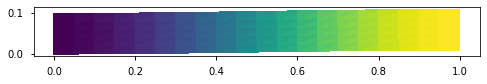

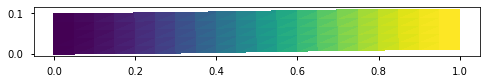

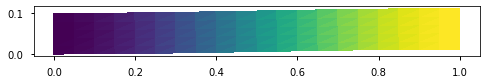

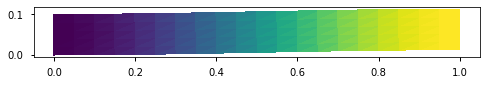

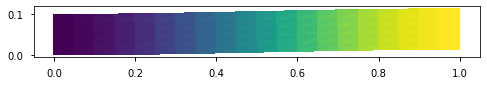

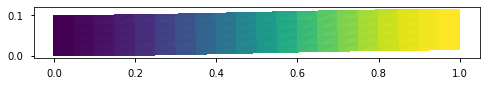

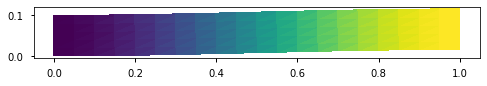

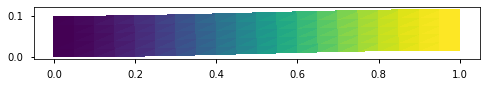

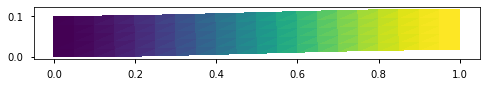

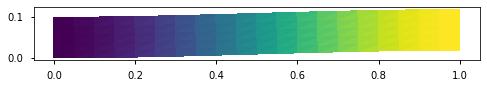

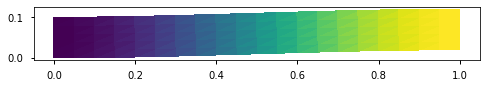

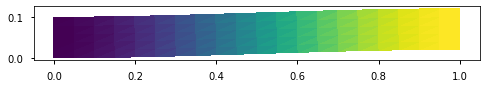

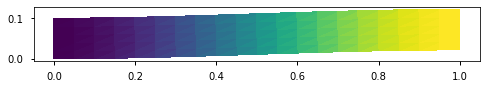

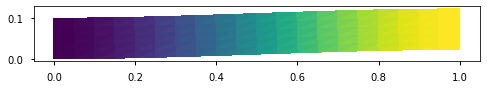

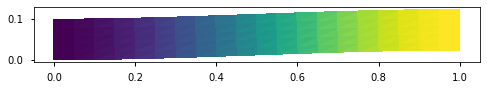

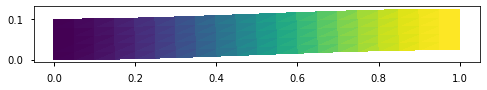

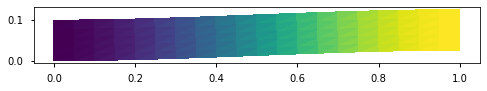

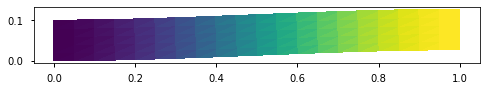

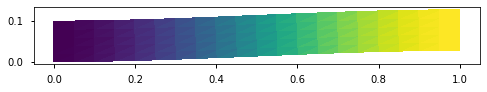

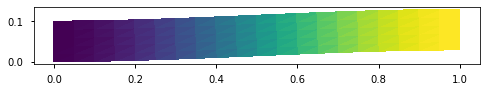

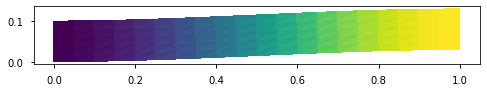

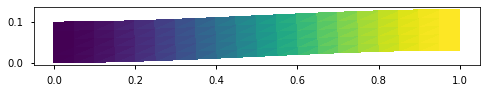

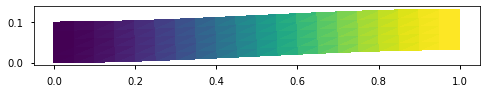

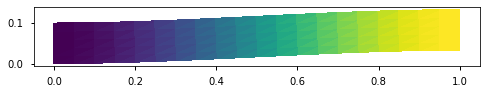

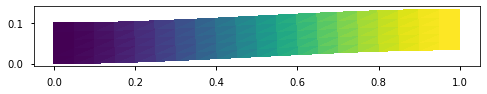

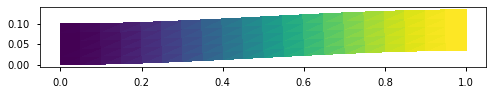

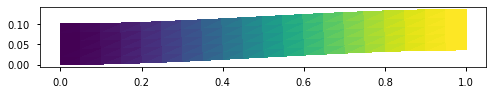

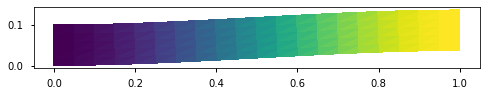

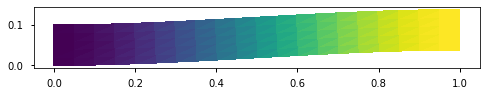

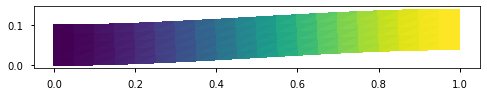

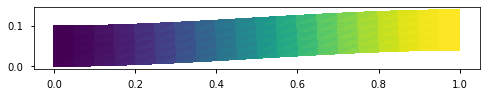

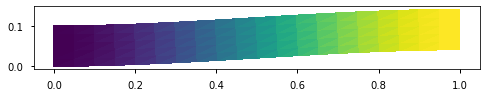

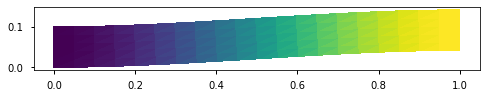

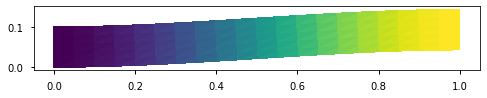

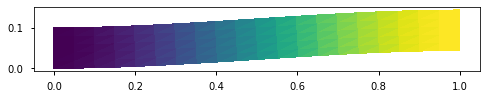

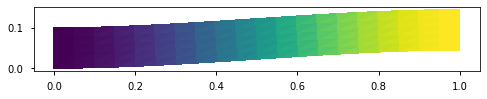

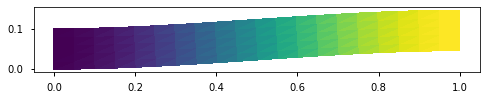

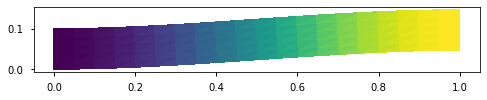

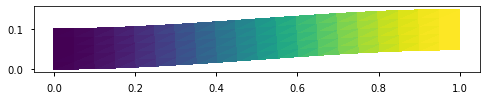

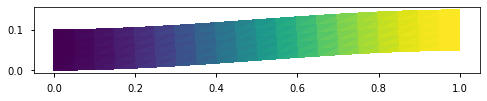

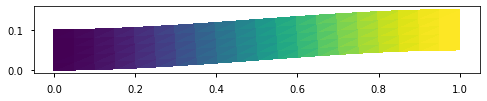

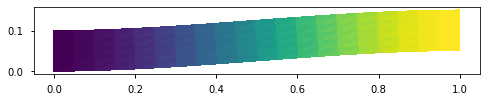

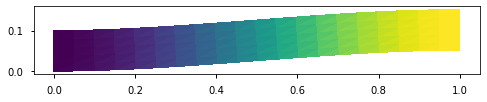

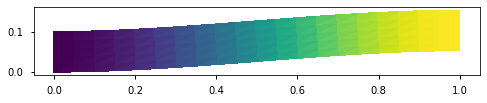

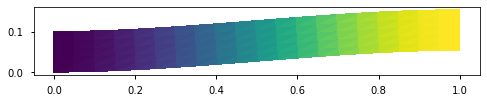

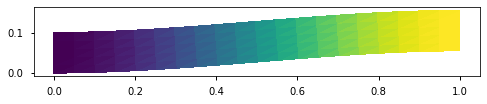

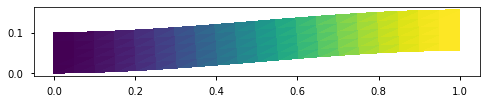

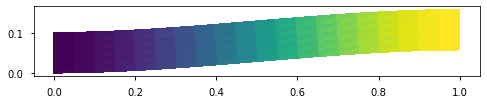

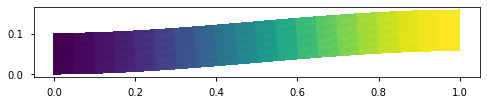

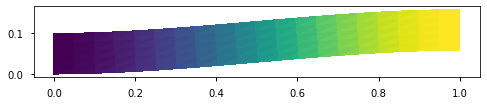

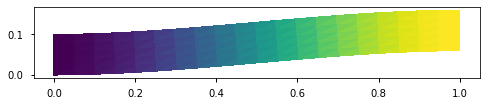

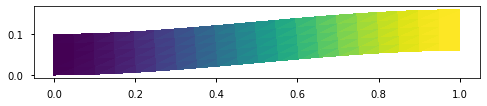

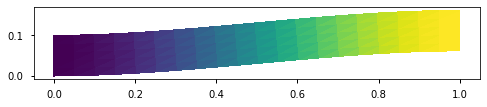

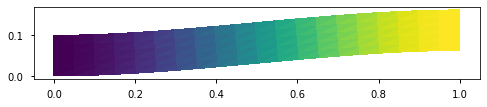

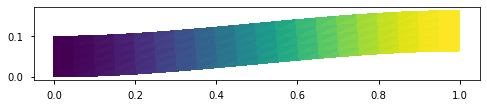

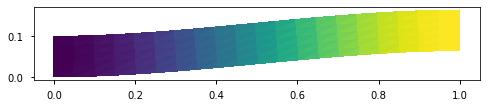

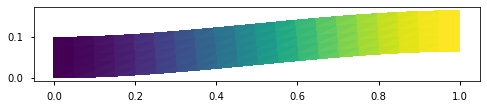

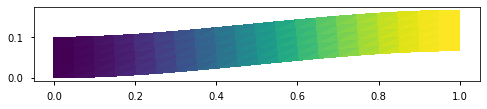

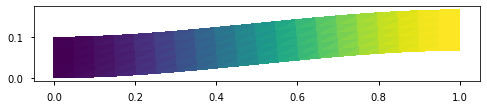

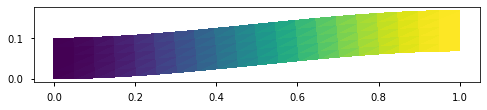

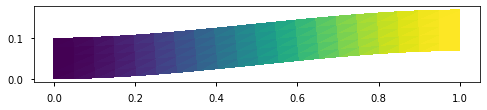

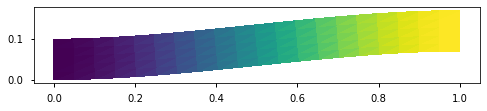

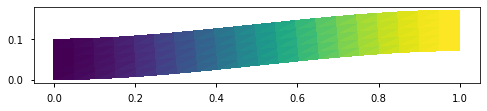

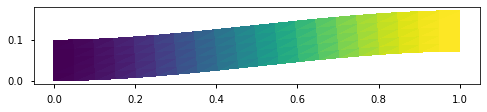

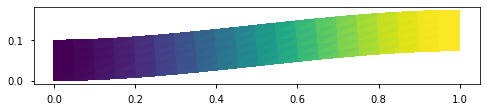

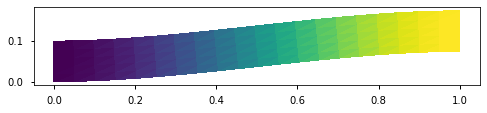

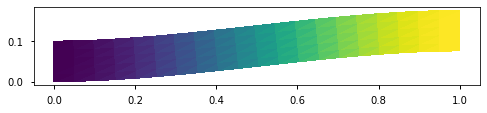

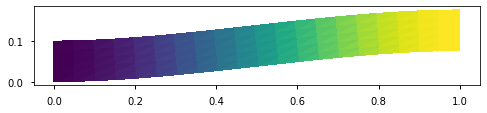

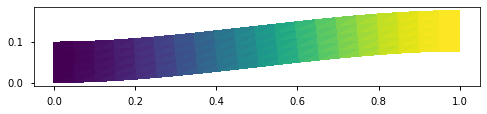

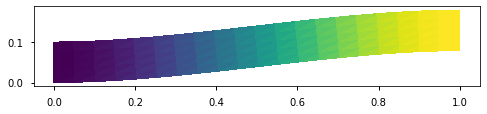

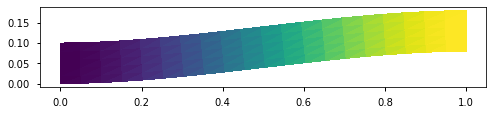

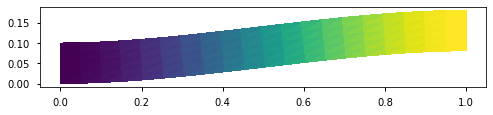

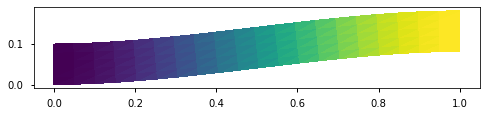

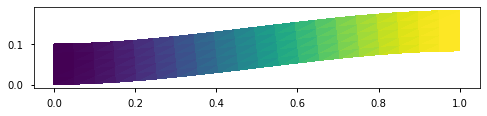

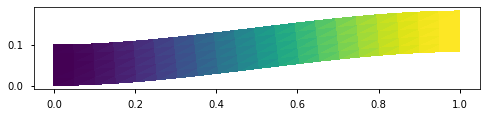

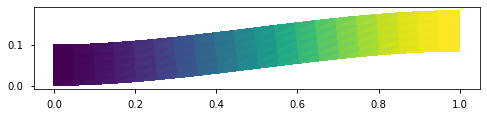

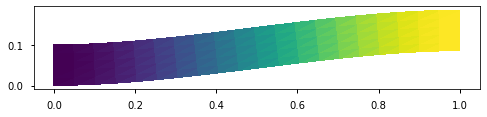

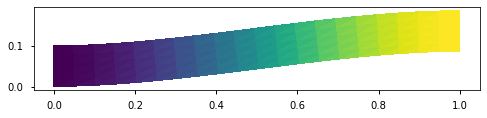

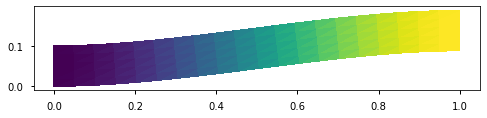

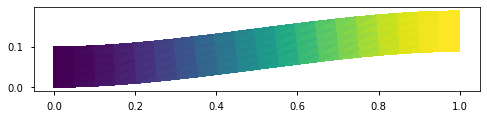

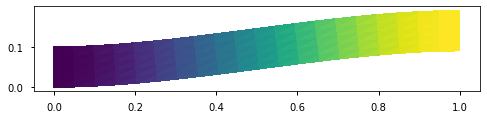

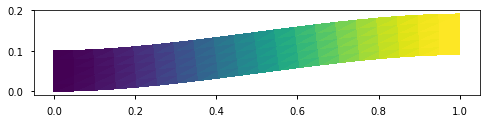

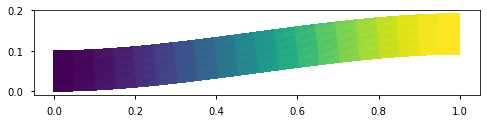

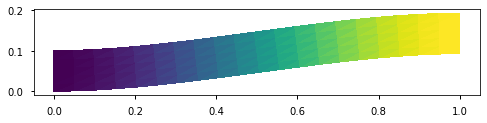

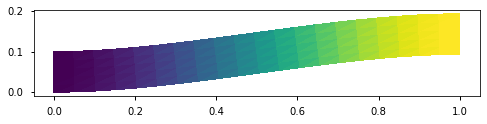

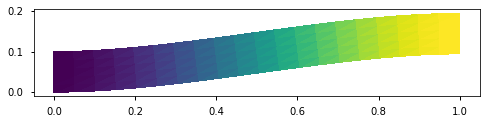

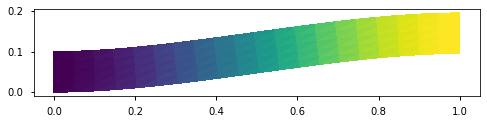

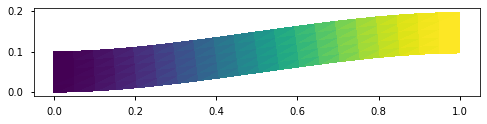

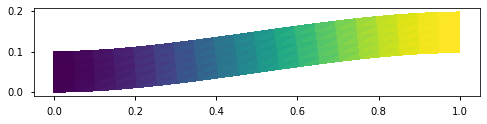

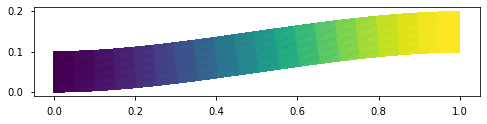

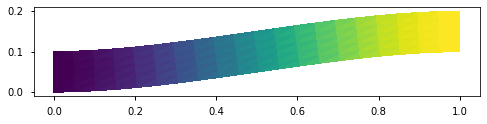

In [67]:
u.interpolate(dolfin.Constant((0., 0.)))
newton_solver(u, monitor=plot_monitor)

**Question 4** For a distributed load equal "mu t (cos(alpha), sin(alpha))" with t = 0.01, plot the displacement as a function of alpha

Text(0, 0.5, 'end-displacement')

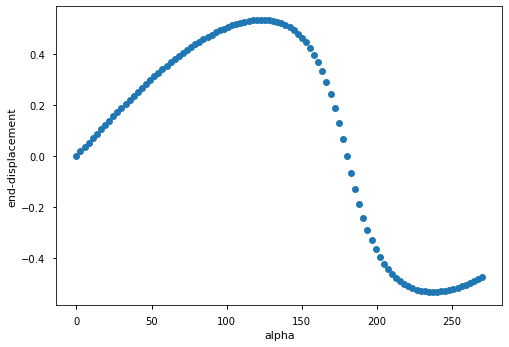

In [44]:
alphas = np.linspace(0, 3*np.pi/2, 100)
displ = np.zeros_like(alphas)
B.t = 0.01

u.interpolate(dolfin.Constant((0.,0.)))
for (i, alpha) in enumerate(alphas):
    B.alpha = alpha
    newton_solver(u)
    displ[i] = dolfin.assemble(u[1]*ds(boundary_indices["right"]))/Ly 

# plt.plot(loads, displ_ref, "-", label='Reference implementation')
plt.plot(alphas*180/np.pi, displ, 'o', label='Our implementation')
plt.xlabel("alpha")
plt.ylabel("end-displacement")
# plt.legend()

**Question 5** Same question with t = 0.02

Text(0, 0.5, 'end-displacement')

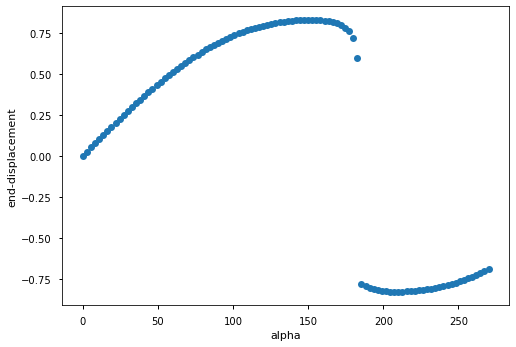

In [43]:
alphas = np.linspace(0, 3*np.pi/2, 100)
displ = np.zeros_like(alphas)
B.t = 0.02

u.interpolate(dolfin.Constant((0.,0.)))
for (i, alpha) in enumerate(alphas):
    B.alpha = alpha
    newton_solver(u)
    displ[i] = dolfin.assemble(u[1]*ds(boundary_indices["right"]))/Ly 

# plt.plot(loads, displ_ref, "-", label='Reference implementation')
plt.plot(alphas*180/np.pi, displ, 'o', label='Our implementation')
plt.xlabel("alpha")
plt.ylabel("end-displacement")
# plt.legend()